# Training & Testing Dataset Preparation

### Metadata

In [1]:
import os
import numpy

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split

# read in train data
TRAINING_DATA_PATH = '../2025_A2/train'
TRAIN_LABEL_PATH = TRAINING_DATA_PATH + '/train_metadata.csv'
IMAGE_DIMENTION = (64, 64)

### Function Definitions



In [2]:
def get_labels(labels_path):
    # load labels as dict 
    labels = {}
    mxm_labels = 0
    with open(labels_path, 'r') as f:
        counter:int = 0
        for line in f:
            # skip the first line
            if counter == 0:
                counter += 1
                continue
            line = line.strip().split(',')
            # line [1] is the image name, line [2] is the label
            labels[line[1]] = int(line[2])
            if int(line[2]) > mxm_labels:
                mxm_labels = int(line[2])
    print(f"Max label: {mxm_labels}")
    return labels

def load_and_preprocess_images(image_folder, labels_dict, target_size=IMAGE_DIMENTION):
    images = []
    labels = []
    
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg"): 
            img_path = os.path.join(image_folder, filename)
            
            # Read image with TensorFlow
            img = tf.io.read_file(img_path)  # Read the image file
            img = tf.image.decode_jpeg(img, channels=3)  # Decode the JPEG image (for JPG files)

            # Resize the image to the target size (100x100)
            img_resized = tf.image.resize(img, target_size)
            
            # Normalize image to [0, 1]
            img_normalized = img_resized / 255.0
            images.append(img_normalized)
            
            # Get the label from the dictionary
            label = labels_dict.get(filename)
            labels.append(label)
    
    # Convert lists to numpy arrays
    images = numpy.array(images)
    labels = numpy.array(labels)
    
    return images, labels

### Prepare Data

In [3]:
overall_images, overall_labels = load_and_preprocess_images(TRAINING_DATA_PATH, get_labels(TRAIN_LABEL_PATH))

X_train, X_test, y_train, y_test = train_test_split(overall_images, overall_labels, test_size=0.2, random_state=42)
# train_images, test_images = tf.keras.utils.split_dataset(
#     overall_images, left_size=0.9)

# train_labels, test_labels = tf.keras.utils.split_dataset(
#     overall_labels, left_size=0.9)


Max label: 42


# Model Definition & Model Training

### Definition

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (9, 9), activation='relu', 
                        input_shape=(IMAGE_DIMENTION[0], IMAGE_DIMENTION[1], 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (6, 6), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(43, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

/opt/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 56, 56, 32)     │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 23, 23, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,923 (730.17 KB)

 Trainable params: 186,923 (730.17 KB)

 Non-trainable params: 0 (0.00 B)

### Train

In [8]:
# model.fit(numpy.array(list(train_images)),
#           numpy.array(list(train_labels)),
#           epochs=10, batch_size=64, callbacks=[tb],
#           validation_data=(numpy.array(list(train_images)), numpy.array(list(train_labels))))

model.fit(X_train,
          y_train,
          epochs=10, batch_size=64, 
         )

Epoch 1/10


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.0794 - loss: 3.5515
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.5313 - loss: 1.9529
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7891 - loss: 0.8301
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8644 - loss: 0.4912
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.9289 - loss: 0.2793
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.9530 - loss: 0.1801
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9484 - loss: 0.2106
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9702 - loss: 0.1006
Epoch 9/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.9775 - loss: 0.0883
Epoch 10/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9835 - loss: 0.0591


# Evaluation

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict
from scikeras.wrappers import KerasClassifier
import numpy as np
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, balanced_accuracy_score,
                             classification_report, f1_score,
                             roc_auc_score, RocCurveDisplay)
import matplotlib.pyplot as plt
import seaborn as sns

# extract the one with highest possibilities
def get_biggest(array_like):
    current_i = 0
    biggest_i = -1
    for i in range(len(array_like)):
        if array_like[i] > biggest_i:
            current_i = i
            biggest_i = array_like[i]
            
    return current_i
# var adapter
y_pred_raw = model.predict(X_test)
y_pred = []
for predict in y_pred_raw:
    y_pred.append(get_biggest(predict))
y_prob = tf.nn.softmax(y_pred_raw)
X = overall_images
y = overall_labels
# model adapter Keras -> sklearn
clf = KerasClassifier(
        model=model,              # build-function
        epochs=10, batch_size=64,
        verbose=0,                   # silence per-epoch logs
        random_state=42              # for reproducibility
)
    

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
[10, 13, 4, 35, 4, 35, 18, 17, 18, 31, 25, 10, 1, 7, 13, 0, 38, 5, 25, 31, 36, 10, 17, 38, 4, 10, 5, 8, 35, 37, 5, 9, 13, 9, 11, 6, 38, 9, 42, 31, 18, 9, 5, 6, 25, 14, 13, 21, 10, 5, 33, 2, 3, 18, 35, 9, 10, 11, 14, 18, 18, 17, 4, 25, 1, 5, 4, 28, 17, 13, 12, 10, 5, 23, 4, 25, 26, 11, 11, 25, 26, 2, 5, 26, 7, 35, 5, 25, 12, 2, 2, 10, 23, 14, 19, 2, 4, 13, 7, 4, 36, 8, 1, 34, 10, 29, 40, 38, 29, 9, 9, 35, 5, 38, 7, 23, 8, 5, 1, 25, 5, 4, 29, 38, 16, 2, 10, 1, 22, 2, 10, 8, 11, 12, 3, 9, 12, 10, 5, 10, 11, 1, 1, 26, 38, 10, 11, 25, 36, 12, 4, 18, 38, 12, 4, 12, 4, 17, 7, 17, 40, 3, 30, 38, 0, 10, 13, 22, 9, 42, 28, 13, 33, 25, 4, 10, 3, 3, 1, 10, 41, 24, 38, 41, 11, 9, 18, 4, 2, 38, 12, 32, 20, 23, 25, 3, 9, 38, 28, 14, 21, 8, 5, 2, 7, 12, 18, 2, 9, 14, 31, 36, 7, 18, 8, 12, 8, 18, 13, 3, 38, 13, 21, 12, 11, 1, 20, 2, 26, 5, 18, 1, 5, 32, 15, 5, 2, 9, 25, 29, 25, 10, 33, 17, 15, 13, 18, 4, 0, 18, 2, 13, 25, 35, 31, 9, 10, 4, 38, 3, 7, 11, 5, 38, 10

Hold-out accuracy : 0.9544626593806922
Balanced accuracy : 0.9289572059265956

Per-class precision / recall / F1

              precision    recall  f1-score   support

           0      1.000     0.889     0.941         9
           1      0.962     0.893     0.926        56
           2      0.893     1.000     0.943        50
           3      0.955     1.000     0.977        42
           4      1.000     0.949     0.974        59
           5      0.946     1.000     0.972        53
           6      1.000     1.000     1.000        14
           7      1.000     0.978     0.989        45
           8      0.972     0.972     0.972        36
           9      0.975     0.951     0.963        41
          10      0.917     1.000     0.957        55
          11      0.976     0.976     0.976        41
          12      0.985     0.985     0.985        65
          13      0.964     1.000     0.982        54
          14      0.952     0.952     0.952        21
          15      0.9

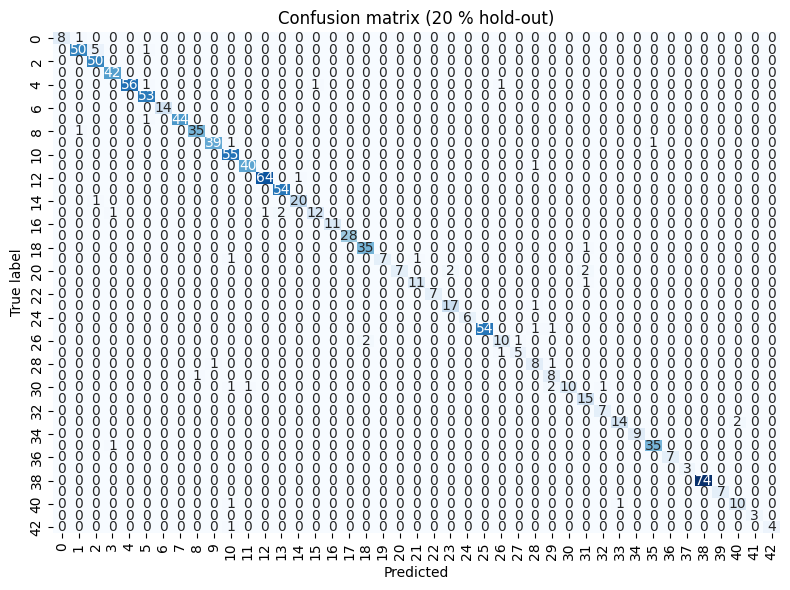

Macro-average ROC-AUC : 0.9963580930377411


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [38]:
# -----------------------------------------------------------
# 1.  Basic metrics on the hold-out set
# -----------------------------------------------------------
print("Hold-out accuracy :", accuracy_score(y_test, y_pred))
print("Balanced accuracy :", balanced_accuracy_score(y_test, y_pred))
print("\nPer-class precision / recall / F1\n")
print(classification_report(y_test, y_pred, digits=3))

# -----------------------------------------------------------
# 2.  Confusion-matrix heat-map
# -----------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues", annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted"); plt.ylabel("True label")
plt.title("Confusion matrix (20 % hold-out)"); plt.tight_layout(); plt.show()
# -----------------------------------------------------------
# 3.  Macro ROC-AUC (one-vs-rest, micro averaged)
# -----------------------------------------------------------
try:
    roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
    print("Macro-average ROC-AUC :", roc_auc)
except Exception as e:
    print("ROC-AUC skipped (classifier lacks predict_proba):", e)

# -----------------------------------------------------------
# 4.  5-fold cross-validation (accuracy & macro-F1)
# -----------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = cross_val_score(clf, X, y,
                             cv=cv, scoring="accuracy", n_jobs=-1)
f1_scores  = cross_val_score(clf, X, y,
                             cv=cv, scoring="f1_macro", n_jobs=-1)

print("\n5-fold CV accuracy : %.3f ± %.3f" % (acc_scores.mean(), acc_scores.std()))
print("5-fold CV F1-macro : %.3f ± %.3f" % (f1_scores.mean(),  f1_scores.std()))

# (Optional) get CV-wide confusion matrix
y_pred_cv = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)
cm_cv = confusion_matrix(y, y_pred_cv)
